# Assignment 3

# Instructions

1. You have to use only this notebook for all your code.
2. All the results and plots should be mentioned in this notebook.
3. For final submission, submit this notebook along with the report ( usual 2-4 pages, latex typeset, which includes the challenges faces and details of additional steps, if any)
4. Marking scheme
    -  **60%**: Your code should be able to detect bounding boxes using resnet 18, correct data loading and preprocessing. Plot any 5 correct and 5 incorrect sample detections from the test set in this notebook for both the approached (1 layer and 2 layer detection), so total of 20 plots.
    -  **20%**: Use two layers (multi-scale feature maps) to detect objects independently as in SSD (https://arxiv.org/abs/1512.02325).  In this method, 1st detection will be through the last layer of Resnet18 and the 2nd detection could be through any layer before the last layer. SSD uses lower resolution layers to detect larger scale objects. 
    -  **20%**: Implement Non-maximum suppression (NMS) (should not be imported from any library) on the candidate bounding boxes.
    
5. Report AP for each of the three class and mAP score for the complete test set.

In [541]:
from __future__ import division, print_function, unicode_literals
import sys
import numpy as np
import os
import xml.etree.ElementTree as ET
import torch
import torch.utils.data as data
from torchvision import models
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from copy import deepcopy
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
# Import other modules if required
# Can use other libraries as well

resnet_input = 224#size of resnet18 input images

In [2]:
# Choose your hyper-parameters using validation data
batch_size = 64
num_epochs = 10
learning_rate =  0.001
hyp_momentum = 0.9

## Build the data
Use the following links to locally download the data:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>The dataset consists of images from 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, i.e. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the three classes(aeroplane, bottle, chair). For parsing the xml file, you can import xml.etree.ElementTree for you. <br/>
<br/> Organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be four. This is important for applying the sliding window method later.


In [3]:
classes = ('__background__',
           'aeroplane',
           'bottle','chair'
           )

from collections import defaultdict

def etree_to_dict(t): # Converts XML etree to JSON
    d = {t.tag: {} if t.attrib else None}
    children = list(t)
    if children:
        dd = defaultdict(list)
        for dc in map(etree_to_dict, children):
            for k, v in dc.items():
                dd[k].append(v)
        d = {t.tag: {k: v[0] if len(v) == 1 else v
                     for k, v in dd.items()}}
    if t.attrib:
        d[t.tag].update(('@' + k, v)
                        for k, v in t.attrib.items())
    if t.text:
        text = t.text.strip()
        if children or t.attrib:
            if text:
              d[t.tag]['#text'] = text
        else:
            d[t.tag] = text
    return d


In [540]:
def build_dataset():
    # Begin
    """
    Finds ground truth bounding boxes in both training and test datasets, and saves as a pickle file
    """
    root_dir = '/data/siddarth/Asgn3/test/VOC2007/'
    image_dir = os.path.join(root_dir, 'JPEGImages')
    annotation_dir = os.path.join(root_dir, 'Annotations')
    
    result = {}
    for filename in os.listdir(annotation_dir):
        f = os.path.join(annotation_dir, filename)
        root = ET.parse(f).getroot()
        obj = etree_to_dict(root)
        img_name = obj['annotation']['filename']
        objt = obj['annotation']['object']
        
        obj_list = []

        if type(objt) is dict:
            if objt['name'] in classes:
#                 print('yes')
                img_file = os.path.join(image_dir, img_name)
                img = Image.open(img_file)
                area = (int(objt['bndbox']['xmin']), int(objt['bndbox']['ymin']), int(objt['bndbox']['xmax']), int(objt['bndbox']['ymax']))
                crop = img.crop(area)

                obj_list.append((area, objt['name']))
                result[img_name] = deepcopy(obj_list)
                
        if type(objt) is list:
            tmp = objt
            obj_list = []
            for objt in tmp:
                if objt['name'] in classes:

                    img_file = os.path.join(image_dir, img_name)
                    img = Image.open(img_file)
                    area = (int(objt['bndbox']['xmin']), int(objt['bndbox']['ymin']), int(objt['bndbox']['xmax']), int(objt['bndbox']['ymax']))
                    crop = img.crop(area)

                    obj_list.append((area, objt['name']))
            if obj_list:
                result[img_name] = deepcopy(obj_list)

        
    return result

# Call build_dataset with appropriate root directory and save file

# with open('test_data_boxes.pkl', 'wb') as f:
#     pkl.dump(build_dataset(), f)
# print(build_dataset())
# build_dataset()


In [536]:
def intersection_over_union(box1, box2):
    x1 = max(box1[0],box2[0])
    x2 = min(box1[2],box2[2])
    y1 = max(box1[1],box2[1])
    y2 = min(box1[3],box2[3])
    if(y2-y1+1>0) and (x2-x1+1>0):
        area_intersection = (y2-y1+1) * (x2-x1+1)
    else:
        area_intersection = 0
    area_box1 = (box1[2]-box1[0]+1)*(box1[3]-box1[1]+1)
    area_box2 = (box2[2]-box2[0]+1)*(box2[3]-box2[1]+1)
    iou = float(area_intersection)/(area_box1+area_box2-area_intersection)
    return iou

def vectorized_iou(x1, y1, x2, y2, ord_indices, last, idx, area):
    
    sx1 = np.maximum(x1[idx], x1[ord_indices[:last]])
    sx2 = np.minimum(x2[idx], x2[ord_indices[:last]])
    sy1 = np.maximum(y1[idx], y1[ord_indices[:last]])
    sy2 = np.minimum(y2[idx], y2[ord_indices[:last]])
 
    area_intersection = np.maximum(0, sy2 - sy1 + 1) * np.maximum(0, sx2 - sx1 + 1)
    iou = area_intersection / area[ord_indices[:last]]
    
    return iou

In [539]:
THRESHOLD = 0.1 # IoU threshold when identifying background

def build_background():
    """
    Identifies background examples from the training dataset
    """
    root_dir = '/data/siddarth/Asgn3/train/VOC2007/'
    image_dir = os.path.join(root_dir, 'JPEGImages')
    annotation_dir = os.path.join(root_dir, 'Annotations')
    
    result = {}
    c = 0
    for filename in os.listdir(annotation_dir):
        f = os.path.join(annotation_dir, filename)
        root = ET.parse(f).getroot()
        obj = etree_to_dict(root)
        
        obj_list = []
        img_name = obj['annotation']['filename']
        objt = obj['annotation']['object']
        
        if type(objt) is dict:
            area = (int(objt['bndbox']['xmin']), int(objt['bndbox']['ymin']), int(objt['bndbox']['xmax']), int(objt['bndbox']['ymax']))
            obj_list.append(area)
                
        if type(objt) is list:
            tmp = objt
            obj_list = []
            for objt in tmp:
                area = (int(objt['bndbox']['xmin']), int(objt['bndbox']['ymin']), int(objt['bndbox']['xmax']), int(objt['bndbox']['ymax']))
                obj_list.append(area)
                
        img_size = obj['annotation']['size']
        w = int(img_size['width'])
        h = int(img_size['height'])
        is_good = True
        while is_good:
            is_good = False
            x_min = np.random.randint(0, w-2)
            y_min = np.random.randint(0, h-2)
            del_x = np.random.randint(1, w-x_min)
            del_y = np.random.randint(1, h-y_min)

            candidate = (x_min, y_min, x_min+del_x, y_min+del_x)
            length = len(obj_list)
            iou_list = []

            for box in obj_list:
                if intersection_over_union(candidate, box) > THRESHOLD:
                    c+=1
                    is_good = True
                    break
        img_file = os.path.join(image_dir, img_name)
        img = Image.open(img_file)
        crop = img.crop(candidate)
        
#         print(candidate)
        
        result[img_name] = (crop, '__background__')      
        
    with open('train_background.pkl', 'wb') as f:
        pkl.dump(result, f)
        
        
# build_background()

In [5]:
class voc_dataset(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # Begin
        self.train = train
        self.transform = transform
        self.root_dir = root_dir
        if train:
            self.dataset = []
            with open('train_data.pkl', 'rb') as f:
                data = pkl.load(f)
                
            for k, v in data.items():
                for x in v:
                    self.dataset.append(x)
#                     plt.imshow(np.asarray(x[0]))
#                     plt.show()
#                     print(x[1])
                    
            with open('train_background.pkl', 'rb') as f:
                data = pkl.load(f)
                
            for k, v in data.items():
                self.dataset.append(v)
#                 plt.imshow(np.asarray(v[0]))
#                 plt.show()
#                 print(v[1])
                
        else:
            self.dataset = []
            with open('test_data.pkl', 'rb') as f:
                data = pkl.load(f)
                
            for k, v in data.items():
                for x in v:
                    self.dataset.append(x)          
            
    def __len__(self):
        # Begin
        if self.train:
            return len(self.dataset)
        else:
            return len(self.dataset)
        
    def __getitem__(self, idx):
       # Begin
        img, label = self.dataset[idx]
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, classes.index(label)
    
# voc_dataset(root_dir='/home/ks1d/Documents/CS783A/Assignment-3/train/VOC2007/', train=True)

## Train the netwok
<br/>You can train the network on the created dataset. This will yield a classification network on the 4 classes of the VOC dataset. 

In [6]:
composed_transform = transforms.Compose([transforms.Scale((resnet_input,resnet_input)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor()
                                         ])
test_transform = transforms.Compose([transforms.Scale((resnet_input, resnet_input)),
                                    transforms.ToTensor()])
train_dataset = voc_dataset(root_dir='/home/ks1d/Documents/CS783A/Assignment-3/train/', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = voc_dataset(root_dir='/home/ks1d/Documents/CS783A/Assignment-3/test/', train=False, transform=composed_transform) # Supply proper root_dir

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Fine-tuning
Use the pre-trained network to fine-tune the network in the following section:

In [7]:
resnet18 = models.resnet18(pretrained=True)

resnet18.fc = nn.Linear(resnet18.fc.in_features, 4)

# Add code for using CUDA here
resnet18 = resnet18.cuda()

In [8]:
criterion = nn.CrossEntropyLoss()
# Update if any errors occur
optimizer = torch.optim.SGD(resnet18.parameters(), learning_rate, hyp_momentum)

In [542]:
def test_acc(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for idx, (x, y) in enumerate(test_loader):
            x = x.cuda(); 
            y = y.cuda()
            output = model(x)
            _, preds = torch.max(output, 1)
            test_loss += criterion(output, y).item() # sum up batch loss
            correct += torch.sum(preds==y.data)

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return 100. * correct / len(test_loader.dataset)

In [10]:
#One Layer Detection
def train():
    max_test_acc = 0
    # Begin
    for epoch in range(num_epochs):
        resnet18.train()
        print("Epoch number {0}".format(epoch+1))
        s = 0
        total_loss = 0
        for idx, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.cuda()
            outputs = resnet18(x)
            _, pred = torch.max(outputs, 1)
            y = y.cuda()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()*x.size(0)
            s+=torch.sum(pred==y.data)
            
            
        print("Epoch loss {0}".format(float(total_loss)/len(train_loader)))
        print("Train Accuracy {0}".format(float(s)/float(len(train_dataset))))
        
        test_accuracy = test_acc(resnet18, test_loader)
        print(test_accuracy)
        if test_accuracy > max_test_acc:
            best_model = resnet18
            max_test_acc = test_accuracy
            
    return best_model
        

In [11]:
%time best_model = train()

Epoch number 1
Epoch loss 28.8928351258
Train Accuracy 0.834233261339

Test set: Average loss: 0.0066, Accuracy: 1997/2342 (85%)

tensor(85, device='cuda:0')
Epoch number 2
Epoch loss 10.7483849854
Train Accuracy 0.942629589633

Test set: Average loss: 0.0058, Accuracy: 2029/2342 (86%)

tensor(86, device='cuda:0')
Epoch number 3
Epoch loss 7.40156141386
Train Accuracy 0.960448164147

Test set: Average loss: 0.0052, Accuracy: 2077/2342 (88%)

tensor(88, device='cuda:0')
Epoch number 4
Epoch loss 5.30130756621
Train Accuracy 0.972057235421

Test set: Average loss: 0.0047, Accuracy: 2112/2342 (90%)

tensor(90, device='cuda:0')
Epoch number 5
Epoch loss 3.81165000591
Train Accuracy 0.981911447084

Test set: Average loss: 0.0053, Accuracy: 2087/2342 (89%)

tensor(89, device='cuda:0')
Epoch number 6
Epoch loss 3.22294589569
Train Accuracy 0.985556155508

Test set: Average loss: 0.0040, Accuracy: 2152/2342 (91%)

tensor(91, device='cuda:0')
Epoch number 7
Epoch loss 2.02473378798
Train Accura

In [538]:
# print(best_model.layer4)

In [225]:
# resnet18 = models.resnet18(pretrained=True)
model = deepcopy(best_model)
for param in model.parameters():
    param.requires_grad = False
model.fc = torch.nn.Linear(512, 4)
model = nn.Sequential(model.conv1, model.bn1, model.relu, model.maxpool, model.layer1, model.layer2, model.layer3, model.layer4[0], model.avgpool, model.fc)
# resnet18 = resnet18.cuda()
model = model.cuda()
optimizer = torch.optim.SGD(model[-1].parameters(), learning_rate, hyp_momentum)

In [226]:
def test_acc_modified(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for idx, (x, y) in enumerate(test_loader):
            x = x.cuda()
            y = y.cuda()
            x = model[:-1](x)
            x = x.view(x.size(0), -1)
            output = model[-1](x)
            _, preds = torch.max(output, 1)
            test_loss += criterion(output, y).item() # sum up batch loss
            correct += torch.sum(preds==y.data)

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return 100. * correct / len(test_loader.dataset)

In [227]:
#Two Layer Detection (SSD)
NUM_EPOCHS = 20
def train_two_layer():
    # Begin
    max_test_acc = 0
    best_model = None
    for epoch in range(NUM_EPOCHS):
        resnet18.train()
        print("Epoch number {0}".format(epoch+1))
        s = 0
        total_loss = 0
        for idx, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.cuda()
#             x = resnet18.conv1(x)
#             x = resnet18.bn1(x)
#             x = resnet18.relu(x)
#             x = resnet18.maxpool(x)

#             x = resnet18.layer1(x)
#             x = resnet18.layer2(x)
#             x = resnet18.layer3(x)
#             x = resnet18.layer4[0](x)
#             x = resnet18.avgpool(x)
#             x = x.view(x.size(0), -1)
#             outputs = resnet18.fc(x)

            x = model[:-1](x)
            x = x.view(x.size(0), -1)
            outputs = model[-1](x)
            _, pred = torch.max(outputs, 1)
            y = y.cuda()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()*x.size(0)
            s+=torch.sum(pred==y.data)
            
            
        print("Epoch loss {0}".format(float(total_loss)/len(train_loader)))
        print("Train Accuracy {0}".format(float(s)/float(len(train_dataset))))
        
        test_accuracy = test_acc_modified(model, test_loader)
        print(test_accuracy)
        if test_accuracy > max_test_acc:
            best_model = model
            max_test_acc = test_accuracy
            
    return best_model

In [228]:
%time best_model_two_layer = train_two_layer()

Epoch number 1
Epoch loss 71.1598514277
Train Accuracy 0.637419006479

Test set: Average loss: 0.0271, Accuracy: 0/2342 (0%)

tensor(0, device='cuda:0')
Epoch number 2
Epoch loss 56.0405011095
Train Accuracy 0.676430885529

Test set: Average loss: 0.0268, Accuracy: 0/2342 (0%)

tensor(0, device='cuda:0')
Epoch number 3
Epoch loss 50.6191619594
Train Accuracy 0.676430885529

Test set: Average loss: 0.0252, Accuracy: 4/2342 (0%)

tensor(0, device='cuda:0')
Epoch number 4
Epoch loss 46.6610493578
Train Accuracy 0.682505399568

Test set: Average loss: 0.0237, Accuracy: 126/2342 (5%)

tensor(5, device='cuda:0')
Epoch number 5
Epoch loss 43.470796322
Train Accuracy 0.714362850972

Test set: Average loss: 0.0223, Accuracy: 373/2342 (15%)

tensor(15, device='cuda:0')
Epoch number 6
Epoch loss 40.8578464245
Train Accuracy 0.746625269978

Test set: Average loss: 0.0212, Accuracy: 573/2342 (24%)

tensor(24, device='cuda:0')
Epoch number 7
Epoch loss 38.623710361
Train Accuracy 0.777807775378

Tes

KeyboardInterrupt: 

# Testing and Accuracy Calculation
For applying detection, use a slding window method to test the above trained trained network on the detection task:<br/>
Take some windows of varying size and aspect ratios and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value. There is a similar approach used in the paper -Faster RCNN by Ross Girshick, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide. You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [15]:
def softmax(outputs):
    probs = torch.exp(outputs)
    probs = probs/torch.sum(probs, 1)
    return probs

In [543]:
window_list = [(90, 180), (180, 90), (181, 362), (362, 181), (45, 90), (90, 45), (64, 64), (128, 128), (256, 256), (200, 200)]
def sliding_window(image, stride, best_model, second=False):
    # Begin
    image = np.asarray(image)
    bottle_list = []
    bottle_list_prob = []
    aeroplane_list = []
    aeroplane_list_prob = []
    chair_list = []
    chair_list_prob = []
    for window in window_list:
        for x in range(0, image.shape[1], stride):
            for y in range(0, image.shape[0], stride):
                window_crop = image[y:y+window[1], x:x+window[0]]

                # Skip if not perfect size
                if window_crop.shape[0]!=window[1] or window_crop.shape[1]!=window[0]:
                    continue
                    
                crop_window = Image.fromarray(window_crop)

                crop_window = test_transform(crop_window)
                crop_window = crop_window.unsqueeze(0)
                crop_window = crop_window.cuda()
                if not second:
                    output = best_model(crop_window)
                else:
                    crop_window = best_model[:-1](crop_window)
                    crop_window = crop_window.view(crop_window.size(0), -1)
                    output = best_model[-1](crop_window)
                    
                output = softmax(output)

                prob, p = torch.max(output, 1)
                p = int(p)
                prob = float(prob) 
                
                if classes[p] == 'bottle':
                    bottle_list.append([x, y, x+window[0], y+window[1]])
                    bottle_list_prob.append(prob)
                if classes[p] == 'aeroplane':
                    aeroplane_list.append([x, y, x+window[0], y+window[1]])
                    aeroplane_list_prob.append(prob)
                if classes[p] == 'chair':
                    chair_list.append([x, y, x+window[0], y+window[1]])
                    chair_list_prob.append(prob)
                    
    return bottle_list, aeroplane_list, chair_list, bottle_list_prob, aeroplane_list_prob, chair_list_prob
            
# img = Image.open('/data/siddarth/Asgn3/test/VOC2007/JPEGImages/000008.jpg')
# bottle_list, aeroplane_list, chair_list, b_prob, a_prob, c_prob = sliding_window(img, 16, best_model)
# print(len(bottle_list))

# bottle_list, aeroplane_list, chair_list, bottle_list_prob, aeroplane_list_prob, chair_list_prob = sliding_window(img, 32, best_model, False)
# n_bottle_list, n_aeroplane_list, n_chair_list, n_bottle_list_prob, n_aeroplane_list_prob, n_chair_list_prob = sliding_window(img, 32, best_model_two_layer, True)

# bottle_list = bottle_list+n_bottle_list
# aeroplane_list = aeroplane_list+n_aeroplane_list
# chair_list = chair_list+n_chair_list
        
# bottle_list_prob = bottle_list_prob+n_bottle_list_prob
# aeroplane_list_prob = aeroplane_list_prob+n_aeroplane_list_prob
# chair_list_prob = chair_list_prob+n_chair_list_prob

Apply non_maximum_supression to reduce the number of boxes. You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [508]:
CONFIDENCE_THRESHOLD = 0.99 # Prune boxes based on prediction confidence of model

In [545]:
import cv2
def non_maximum_supression(box_prob_zip_list, threshold = 0.15):
    # Begin
    if len(box_prob_zip_list) == 0:
        return ([], [])
    
    [boxes, probability_list] = list(zip(*box_prob_zip_list))
#     print(boxes)
    boxes = list(boxes)
    probability_list = list(probability_list)
    
    assert len(probability_list)==len(boxes)
    
    boxes = np.asarray(boxes)
    probability_list = np.asarray(probability_list)
    
    v = probability_list > CONFIDENCE_THRESHOLD
    probability_list = probability_list[v]
    boxes = boxes[v]
    
    final = []
    
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    ord_indices = np.argsort(probability_list)
    ord_indices = ord_indices[:9]
    
    while len(ord_indices) > 0:
        last = len(ord_indices) - 1
        idx = ord_indices[last]
        final.append(idx)
 
        iou = vectorized_iou(x1=x1, y1=y1, x2=x2, y2=y2, area=area, idx=idx, last=last, ord_indices=ord_indices) # Compute iou
        tmp = iou > threshold
        tmp2 = np.arange(tmp.shape[0])
        tmp = tmp2[tmp]
        ord_indices = np.delete(ord_indices, np.concatenate(([last], tmp)))
 
    return (boxes[final], probability_list[final])

# bottle_zip = list(zip(bottle_list, b_prob))
# aeroplane_zip = list(zip(aeroplane_list, a_prob))
# chair_zip = list(zip(chair_list, c_prob))
# [(bottle_bxs, bp), (aeroplane_bxs, ap), (chair_bxs, cp)] = map(non_maximum_supression, [bottle_zip, aeroplane_zip, chair_zip])
# img = cv2.imread('/data/siddarth/Asgn3/test/VOC2007/JPEGImages/000008.jpg')
# for b in bottle_bxs:
#     cv2.rectangle(img, (b[0], b[1]), (b[2], b[3]), (255,0,0), 2)

# for b in aeroplane_bxs:
#     cv2.rectangle(img, (b[0], b[1]), (b[2], b[3]), (0,255,0), 2)
    
# for b in chair_bxs:
#     cv2.rectangle(img, (b[0], b[1]), (b[2], b[3]), (0,0,255), 2)
    
# img = Image.fromarray(img)
# plt.imshow(img)
# plt.show()

Test the trained model on the test dataset.

Test examples
Correct


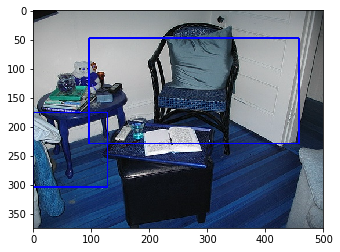

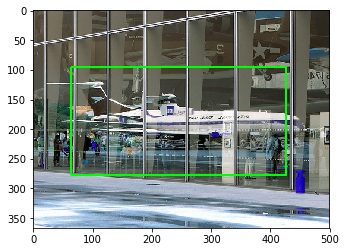

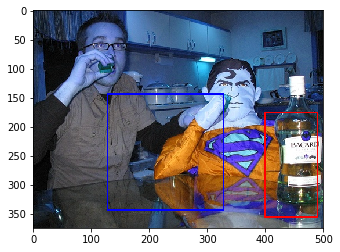

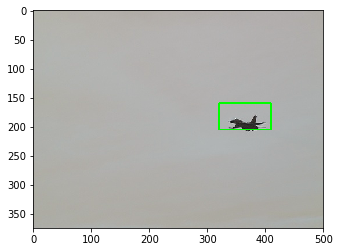

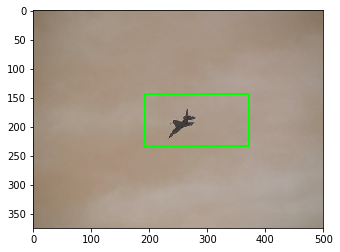

Incorrect


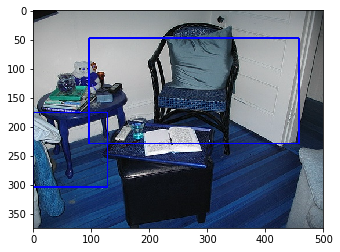

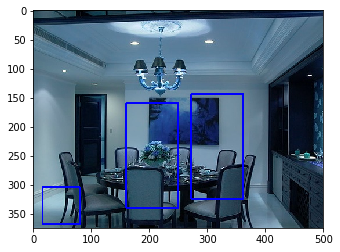

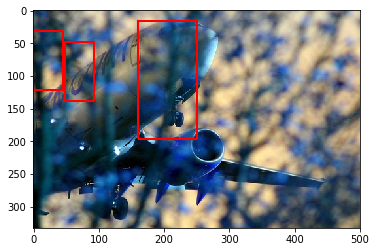

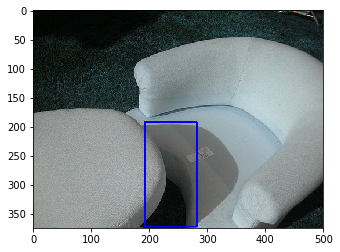

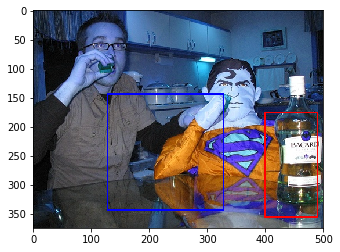

In [493]:
def print_img(img_list, train=False):
    if not train:
        root = '/data/siddarth/Asgn3/test/VOC2007/JPEGImages/'
    else:
        root = '/data/siddarth/Asgn3/train/VOC2007/JPEGImages/'
        
    for img in img_list:
        img_path = os.path.join(root, img)
        img = Image.open(img_path)
        bottle_list, aeroplane_list, chair_list, b_prob, a_prob, c_prob = sliding_window(img, 16, best_model)
        
        bottle_zip = list(zip(bottle_list, b_prob))
        aeroplane_zip = list(zip(aeroplane_list, a_prob))
        chair_zip = list(zip(chair_list, c_prob))
        [(bottle_bxs, bp), (aeroplane_bxs, ap), (chair_bxs, cp)] = map(non_maximum_supression, [bottle_zip, aeroplane_zip, chair_zip])
        img = cv2.imread(img_path)
        for b in bottle_bxs:
            cv2.rectangle(img, (b[0], b[1]), (b[2], b[3]), (255,0,0), 2)

        for b in aeroplane_bxs:
            cv2.rectangle(img, (b[0], b[1]), (b[2], b[3]), (0,255,0), 2)

        for b in chair_bxs:
            cv2.rectangle(img, (b[0], b[1]), (b[2], b[3]), (0,0,255), 2)

        img = Image.fromarray(img)
        plt.imshow(img)
        plt.show()
#         break

print("Test examples")
print("Correct")
test_p = ['000008.jpg', '000128.jpg', '000202.jpg', '000316.jpg', '000216.jpg']        
print_img(test_p, False)
print("Incorrect")
test_f = ['000008.jpg', '000510.jpg', '000600.jpg', '000905.jpg', '000202.jpg']
print_img(test_f, False)

2 layer
Correct


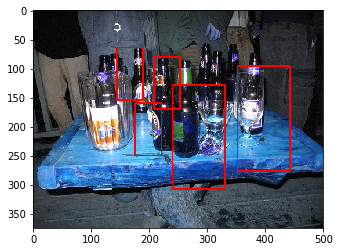

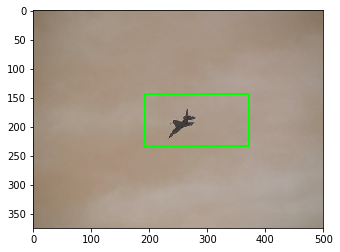

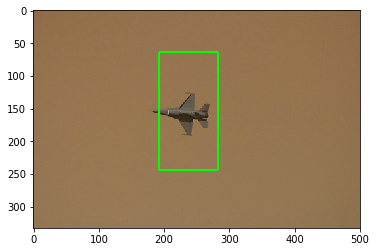

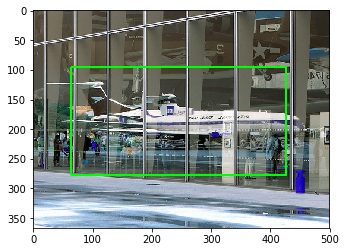

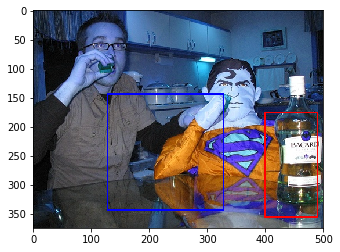

Incorrect


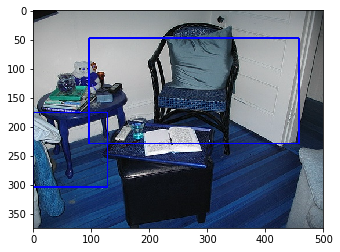

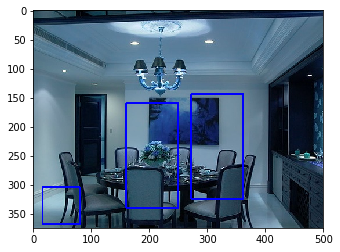

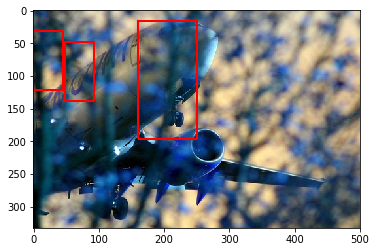

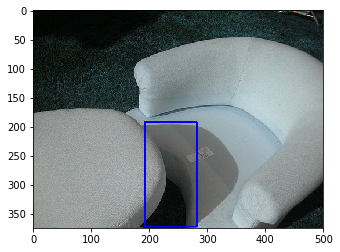

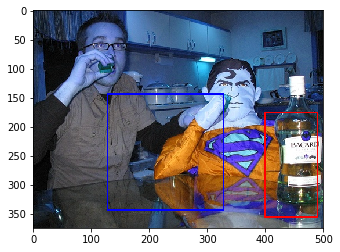

In [522]:
def print_2(img_list):
    root = '/data/siddarth/Asgn3/test/VOC2007/JPEGImages/'
    for img in img_list:
        img_path = os.path.join(root, img)
        img = Image.open(img_path)
        
        bottle_list, aeroplane_list, chair_list, bottle_list_prob, aeroplane_list_prob, chair_list_prob = sliding_window(img, 16, best_model, False)
        n_bottle_list, n_aeroplane_list, n_chair_list, n_bottle_list_prob, n_aeroplane_list_prob, n_chair_list_prob = sliding_window(img, 16, best_model_two_layer, True)

        bottle_list = bottle_list+n_bottle_list
        aeroplane_list = aeroplane_list+n_aeroplane_list
        chair_list = chair_list+n_chair_list

        b_prob = bottle_list_prob+n_bottle_list_prob
        a_prob = aeroplane_list_prob+n_aeroplane_list_prob
        c_prob = chair_list_prob+n_chair_list_prob
        
        bottle_zip = list(zip(bottle_list, b_prob))
        aeroplane_zip = list(zip(aeroplane_list, a_prob))
        chair_zip = list(zip(chair_list, c_prob))
        [(bottle_bxs, bp), (aeroplane_bxs, ap), (chair_bxs, cp)] = map(non_maximum_supression, [bottle_zip, aeroplane_zip, chair_zip])
        img = cv2.imread(img_path)
        for b in bottle_bxs:
            cv2.rectangle(img, (b[0], b[1]), (b[2], b[3]), (255,0,0), 2)

        for b in aeroplane_bxs:
            cv2.rectangle(img, (b[0], b[1]), (b[2], b[3]), (0,255,0), 2)

        for b in chair_bxs:
            cv2.rectangle(img, (b[0], b[1]), (b[2], b[3]), (0,0,255), 2)

        img = Image.fromarray(img)
        plt.imshow(img)
        plt.show()
#         break
    
print("2 layer")
n_test_p = ['000178.jpg', '000216.jpg', '000243.jpg', '000128.jpg', '000202.jpg']
n_test_f = ['000008.jpg', '000510.jpg', '000600.jpg', '000905.jpg', '000202.jpg']
print('Correct')
print_2(n_test_p)
print("Incorrect")
print_2(n_test_f)

In [192]:
"""
Computes AP for class. Taken from: https://gist.github.com/tarlen5/008
809c3decf19313de216b9208f3734
"""
"""
author: Timothy C. Arlen
date: 28 Feb 2018

Calculate Mean Average Precision (mAP) for a set of bounding boxes corresponding to specific
image Ids. Usage:

> python calculate_mean_ap.py

Will display a plot of precision vs recall curves at 10 distinct IoU thresholds as well as output
summary information regarding the average precision and mAP scores.

NOTE: Requires the files `ground_truth_boxes.json` and `predicted_boxes.json` which can be
downloaded fromt this gist.
"""

from __future__ import absolute_import, division, print_function

from copy import deepcopy
import json
import glob
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns

# sns.set_style('white')
# sns.set_context('poster')

COLORS = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']


def calc_iou_individual(pred_box, gt_box):
    """Calculate IoU of single predicted and ground truth box

    Args:
        pred_box (list of floats): location of predicted object as
            [xmin, ymin, xmax, ymax]
        gt_box (list of floats): location of ground truth object as
            [xmin, ymin, xmax, ymax]

    Returns:
        float: value of the IoU for the two boxes.

    Raises:
        AssertionError: if the box is obviously malformed
    """
    x1_t, y1_t, x2_t, y2_t = gt_box
    x1_p, y1_p, x2_p, y2_p = pred_box

    if (x1_p > x2_p) or (y1_p > y2_p):
        raise AssertionError(
            "Prediction box is malformed? pred box: {}".format(pred_box))
    if (x1_t > x2_t) or (y1_t > y2_t):
        raise AssertionError(
            "Ground Truth box is malformed? true box: {}".format(gt_box))

    if (x2_t < x1_p or x2_p < x1_t or y2_t < y1_p or y2_p < y1_t):
        return 0.0

    far_x = np.min([x2_t, x2_p])
    near_x = np.max([x1_t, x1_p])
    far_y = np.min([y2_t, y2_p])
    near_y = np.max([y1_t, y1_p])

    inter_area = (far_x - near_x + 1) * (far_y - near_y + 1)
    true_box_area = (x2_t - x1_t + 1) * (y2_t - y1_t + 1)
    pred_box_area = (x2_p - x1_p + 1) * (y2_p - y1_p + 1)
    iou = inter_area / (true_box_area + pred_box_area - inter_area)
    return iou


def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.

    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.

    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """

    all_pred_indices = range(len(pred_boxes))
    all_gt_indices = range(len(gt_boxes))
    if len(all_pred_indices) == 0:
        tp = 0
        fp = 0
        fn = len(gt_boxes)
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}
    if len(all_gt_indices) == 0:
        tp = 0
        fp = len(pred_boxes)
        fn = 0
        return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}

    gt_idx_thr = []
    pred_idx_thr = []
    ious = []
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou = calc_iou_individual(pred_box, gt_box)
            if iou > iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)

    args_desc = np.argsort(ious)[::-1]
    if len(args_desc) == 0:
        # No matches
        tp = 0
        fp = len(pred_boxes)
        fn = len(gt_boxes)
    else:
        gt_match_idx = []
        pred_match_idx = []
        for idx in args_desc:
            gt_idx = gt_idx_thr[idx]
            pr_idx = pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if (gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp = len(gt_match_idx)
        fp = len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)

    return {'true_pos': tp, 'false_pos': fp, 'false_neg': fn}


def calc_precision_recall(img_results):
    """Calculates precision and recall from the set of images

    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }

    Returns:
        tuple: of floats of (precision, recall)
    """
    true_pos = 0; false_pos = 0; false_neg = 0
    for _, res in img_results.items():
        true_pos += res['true_pos']
        false_pos += res['false_pos']
        false_neg += res['false_neg']

    try:
        precision = true_pos/(true_pos + false_pos)
    except ZeroDivisionError:
        precision = 0.0
    try:
        recall = true_pos/(true_pos + false_neg)
    except ZeroDivisionError:
        recall = 0.0

    return (precision, recall)

def get_model_scores_map(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.

    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'

    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)

    """
    model_scores_map = {}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_scores_map.keys():
                model_scores_map[score] = [img_id]
            else:
                model_scores_map[score].append(img_id)
    return model_scores_map

def get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=0.5):
    """Calculates average precision at given IoU threshold.

    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (list of list of floats): list of locations of predicted
            objects as [xmin, ymin, xmax, ymax]
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.

    Returns:
        dict: avg precision as well as summary info about the PR curve

        Keys:
            'avg_prec' (float): average precision for this IoU threshold
            'precisions' (list of floats): precision value for the given
                model_threshold
            'recall' (list of floats): recall value for given
                model_threshold
            'models_thrs' (list of floats): model threshold value that
                precision and recall were computed for.
    """
    model_scores_map = get_model_scores_map(pred_boxes)
    sorted_model_scores = sorted(model_scores_map.keys())

    # Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_boxes.keys():
        arg_sort = np.argsort(pred_boxes[img_id]['scores'])
        pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
        pred_boxes[img_id]['boxes'] = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

    pred_boxes_pruned = deepcopy(pred_boxes)

    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}
    # Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
        # On first iteration, define img_results for the first time:
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores_map[model_score_thr]
        for img_id in img_ids:
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break

            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores'] = pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes'] = pred_boxes_pruned[img_id]['boxes'][start_idx:]

            # Recalculate image results for this image
            img_results[img_id] = get_single_image_results(
                gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)

        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec)

    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}

def fun(gt_boxes, pred_boxes):
    iou_thr = 0.5
    start_time = time.time()
    data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
    end_time = time.time()
    print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
    print('avg precision: {:.4f}'.format(data['avg_prec']))

    start_time = time.time()
    avg_precs = []
    iou_thrs = []
    for idx, iou_thr in enumerate(np.linspace(0.5, 0.95, 10)):
        data = get_avg_precision_at_iou(gt_boxes, pred_boxes, iou_thr=iou_thr)
        avg_precs.append(data['avg_prec'])
        iou_thrs.append(iou_thr)

        precisions = data['precisions']
        recalls = data['recalls']

    avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
    iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
    print('map: {:.2f}'.format(100*np.mean(avg_precs)))
    print('avg precs: ', avg_precs)
    print('iou_thrs:  ', iou_thrs)

    end_time = time.time()
    print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))



In [265]:
#One Layer Detection
d_chair_p = {}
d_chair_gt = {}
d_aeroplane_p = {}
d_aeroplane_gt = {}
d_bottle_p = {}
d_bottle_gt = {}

def test(resnet18):
    score_chair = 0
    score_aeroplane = 0
    score_bottle = 0
    ctr = 0
    root_dir = '/data/siddarth/Asgn3/test/VOC2007/'
    image_dir = os.path.join(root_dir, 'JPEGImages')
    annotation_dir = os.path.join(root_dir, 'Annotations')
    
    with open('test_data_boxes.pkl', 'rb') as f:
        data = pkl.load(f)
        
    for img_name, v in data.items():
        img_path = os.path.join(image_dir, img_name)
        im = Image.open(img_path)
        
        bottle_list, aeroplane_list, chair_list, bottle_list_prob, aeroplane_list_prob, chair_list_prob = sliding_window(im, 32, best_model, False)
        bottle_zip = list(zip(bottle_list, bottle_list_prob))
        aeroplane_zip = list(zip(aeroplane_list, aeroplane_list_prob))
        chair_zip = list(zip(chair_list, chair_list_prob))
    
        [(bottle_pred, bp), (aeroplane_pred, ap), (chair_pred, cp)] = map(non_maximum_supression, [bottle_zip, aeroplane_zip, chair_zip])
        bottle_gt = [list(u[0]) for u in v if u[1] == 'bottle']
        aeroplane_gt = [list(u[0]) for u in v if u[1] == 'aeroplane']
        chair_gt = [list(u[0]) for u in v if u[1] == 'chair']
        d_chair_gt[img_name] = chair_gt
        d_chair_p[img_name] = {}
        d_chair_p[img_name]['boxes'] = chair_pred
        d_chair_p[img_name]['scores'] = cp
        
        d_aeroplane_gt[img_name] = aeroplane_gt
        d_aeroplane_p[img_name] = {}
        d_aeroplane_p[img_name]['boxes'] = aeroplane_pred
        d_aeroplane_p[img_name]['scores'] = ap
        
        d_bottle_gt[img_name] = bottle_gt
        d_bottle_p[img_name] = {}
        d_bottle_p[img_name]['boxes'] = bottle_pred
        d_bottle_p[img_name]['scores'] = bp
        
        ctr += 1
        if ctr == 10:
            break

# test(best_model)


In [266]:
def compute_map():
    ap_chair = get_avg_precision_at_iou(d_chair_gt, d_chair_p, iou_thr=0.5)['avg_prec']
    ap_aeroplane = get_avg_precision_at_iou(d_aeroplane_gt, d_aeroplane_p, iou_thr=0.5)['avg_prec']
    ap_bottle = get_avg_precision_at_iou(d_bottle_gt, d_bottle_p, iou_thr=0.5)['avg_prec']
    
    print("Avg precision of chair {0}".format(ap_chair))
    print("Avg precision of aeroplane {0}".format(ap_aeroplane))
    print("Avg precision of bottle {0}".format(ap_bottle))
    
    print("Mean Avg Precision {0}".format((ap_chair+ap_aeroplane+ap_bottle)/3.0))

In [267]:
# compute_map()

In [268]:
%time test(best_model)
%time compute_map()

CPU times: user 1h 17min 38s, sys: 5min 1s, total: 1h 22min 40s
Wall time: 1h 23min 12s
Avg precision of chair 0.0755441741357
Avg precision of aeroplane 0.141119486574
Avg precision of bottle 0.0909090909091
Mean Avg Precision 0.10252425054
CPU times: user 1.2 s, sys: 0 ns, total: 1.2 s
Wall time: 1.22 s


In [ ]:
#Two Layer Detection
d_chair_p = {}
d_chair_gt = {}
d_aeroplane_p = {}
d_aeroplane_gt = {}
d_bottle_p = {}
d_bottle_gt = {}
def test_two_layer(resnet18):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model

    score_chair = 0
    score_aeroplane = 0
    score_bottle = 0
    ctr = 0
    root_dir = '/data/siddarth/Asgn3/test/VOC2007/'
    image_dir = os.path.join(root_dir, 'JPEGImages')
    annotation_dir = os.path.join(root_dir, 'Annotations')
    
    with open('test_data_boxes.pkl', 'rb') as f:
        data = pkl.load(f)
        
    for img_name, v in data.items():
        img_path = os.path.join(image_dir, img_name)
        im = Image.open(img_path)
        
        bottle_list, aeroplane_list, chair_list, bottle_list_prob, aeroplane_list_prob, chair_list_prob = sliding_window(im, 32, best_model, False)
        n_bottle_list, n_aeroplane_list, n_chair_list, n_bottle_list_prob, n_aeroplane_list_prob, n_chair_list_prob = sliding_window(im, 32, best_model_two_layer, True)
        
        bottle_list = bottle_list+n_bottle_list
        aeroplane_list = aeroplane_list+n_aeroplane_list
        chair_list = chair_list+n_chair_list
        
        bottle_list_prob = bottle_list_prob+n_bottle_list_prob
        aeroplane_list_prob = aeroplane_list_prob+n_aeroplane_list_prob
        chair_list_prob = chair_list_prob+n_chair_list_prob
        
        bottle_zip = list(zip(bottle_list, bottle_list_prob))
        aeroplane_zip = list(zip(aeroplane_list, aeroplane_list_prob))
        chair_zip = list(zip(chair_list, chair_list_prob))
    
        [(bottle_pred, bp), (aeroplane_pred, ap), (chair_pred, cp)] = map(non_maximum_supression, [bottle_zip, aeroplane_zip, chair_zip])
        bottle_gt = [list(u[0]) for u in v if u[1] == 'bottle']
        aeroplane_gt = [list(u[0]) for u in v if u[1] == 'aeroplane']
        chair_gt = [list(u[0]) for u in v if u[1] == 'chair']
        d_chair_gt[img_name] = chair_gt
        d_chair_p[img_name] = {}
        d_chair_p[img_name]['boxes'] = chair_pred
        d_chair_p[img_name]['scores'] = cp
        
        d_aeroplane_gt[img_name] = aeroplane_gt
        d_aeroplane_p[img_name] = {}
        d_aeroplane_p[img_name]['boxes'] = aeroplane_pred
        d_aeroplane_p[img_name]['scores'] = ap
        
        d_bottle_gt[img_name] = bottle_gt
        d_bottle_p[img_name] = {}
        d_bottle_p[img_name]['boxes'] = bottle_pred
        d_bottle_p[img_name]['scores'] = bp
        
        ctr += 1

In [ ]:
%time two_layer_test(resnet18)